# 📍Minor Project
## "What's on Menu" 🍔🍟

Project by Maria Bocharova, Ksenya Danilova, Anna Kryganova 

In [114]:
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

### 1. Предобработка таблиц

In [77]:
Dish = pd.read_csv("Dish.csv", sep=",")
Dish = Dish.drop('description', 1)
Dish = Dish.rename(columns={'id': 'dish_id'})

MenuItem = pd.read_csv("MenuItem.csv", sep=",")
MenuItem = MenuItem[["id", "price", "dish_id", "menu_page_id"]]
MenuItem["dish_id"] = MenuItem["dish_id"].fillna(0.0).astype(int)

# Объединяем таблицы Dish и MenuItem
Dish_MenuItem = pd.merge(Dish, MenuItem, on=('dish_id'), how ='left')

MenuPage = pd.read_csv("MenuPage.csv", sep=",")
MenuPage = MenuPage[["id", "menu_id"]]
MenuPage = MenuPage.rename(columns={'id': 'menu_page_id'})

# Объединяем таблицы Dish_MenuItem и MenuPage
MenuPage_Dish_MenuItem = pd.merge(Dish_MenuItem, MenuPage, on=('menu_page_id'), how ='left')

Menu = pd.read_csv("Menu.csv", sep=",")
Menu = Menu[["id", "sponsor", "event", "place", "occasion", "date", "location", "page_count", "dish_count"]]
Menu = Menu.rename(columns={'id': 'menu_id'})

# Объединяем таблицы все таблицы в одну
FinalMenu = pd.merge(MenuPage_Dish_MenuItem, Menu, on=('menu_id'), how ='left')
FinalMenu = FinalMenu[["dish_id", "name", "menus_appeared", "times_appeared", 
                       "first_appeared", "last_appeared", "lowest_price", 
                       "highest_price", "price", "sponsor", "event", "place", 
                       "occasion", "date", "location"]]

In [78]:
# Приводим дату к виду 1900 (вместо 1900-01-01)
def fixing_date(date):
    return float(str(date).split('-')[0])


FinalMenu['date'] = FinalMenu['date'].apply(fixing_date)

In [83]:
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w).lower() for w in w_tokenizer.tokenize(text)])


w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
# Лемматизируем столбец "name"
FinalMenu['name_lemm'] = FinalMenu['name'].apply(lemmatize_text)

# Лемматизируем столбец "place"
FinalMenu['place_lemm'] = FinalMenu['place'].dropna().apply(lemmatize_text)

In [260]:
FinalMenu.head()

,dish_id,name,menus_appeared,times_appeared,first_appeared,last_appeared,lowest_price,highest_price,price,sponsor,event,place,occasion,date,location,name_lemm,place_lemm
0,1,Consomme printaniere royal,8,8,1897,1927,0.2,0.4,0.4,CLAREMONT HOTEL,MENU,NaN,NaN,1900.0,Claremont Hotel,consomme printaniere royal,NaN
1,1,Consomme printaniere royal,8,8,1897,1927,0.2,0.4,NaN,CAFE BOULEVARD,SUNDAY DINNER,156 SECOND AVENUE (NY?),NaN,1900.0,Cafe Boulevard,consomme printaniere royal,156 second avenue (ny?)
2,1,Consomme printaniere royal,8,8,1897,1927,0.2,0.4,0.2,DENISON HOTEL,CHRISTMAS DINNER,"INDIANAPOLIS, IN",RELIGIOUS HOLIDAY,1906.0,Denison Hotel,consomme printaniere royal,"indianapolis, in"
3,1,Consomme printaniere royal,8,8,1897,1927,0.2,0.4,0.4,NaN,NaN,NaN,NaN,1900.0,Claremont Hotel,consomme printaniere royal,NaN
4,1,Consomme printaniere royal,8,8,1897,1927,0.2,0.4,NaN,SPRINGFIELD CALEDONIANS,FOURTEENTH BURNS ANNIVERSARY,HOTEL WORTHY,ANNIVERSARY;,1897.0,Springfield Caledonians,consomme printaniere royal,hotel worthy


### 2. График изменения цены блюда

In [268]:
dish_name = input()
Dish = FinalMenu[['name_lemm', 'date', 'price']].dropna()
Dish = Dish[Dish['name_lemm'] == dish_name]
Dish = Dish.loc[Dish['price'] > 0]
Dish = Dish.loc[Dish['date'] <= 2021]
Dish = Dish.loc[Dish['date'] >= 1000]

coffee


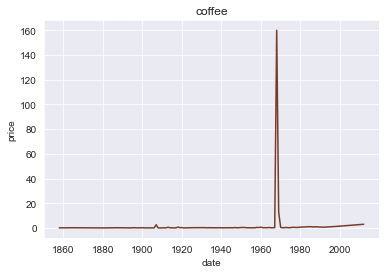

In [269]:
YearPrice = Dish.groupby("date", as_index = False).agg({"price": "mean"})
sns.set_style('darkgrid')
graph = sns.lineplot(x='date', y='price', data=YearPrice, color="#763c28").set_title(dish_name)
pic = graph.get_figure()
#pic.savefig(f'{dish_name}.png', bbox_inches='tight', dpi=400) 

### 3. Топ позиций в меню в университетах 

- Всего 47 университетов и 9 университетских клубов 

In [198]:
University = FinalMenu.groupby('location', as_index = False).agg({"name_lemm": list})
University = University[University.apply(lambda x: 'University' in x['location'], axis=1)]

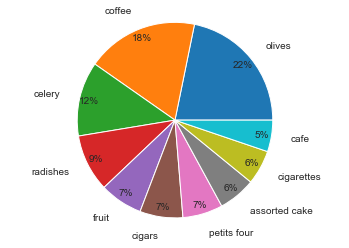

In [211]:
def get_piechart(df):
    dishes = []
    sep_dishes = df['name_lemm'].values.tolist()
    for i in sep_dishes:
        dishes.extend(i)

    dish_freq = Counter(dishes).most_common(10)
    labels = []
    sizes = []
    for x, y in dish_freq :
        labels.append(x)
        sizes.append(y)


    plt.pie(sizes, labels=labels, autopct='%1.0f%%', pctdistance=0.9, labeldistance=1.2)
    plt.axis('equal')
    plt.show()
    
    
get_piechart(University)

### 3. Топ позиций в меню в определенном месте

In [249]:
# Таблица place_lemm и name_lemm, где place_lemm содержит определенное место (страна, штат, город)
def get_db_location_dish(place_name: str):
    db = FinalMenu.groupby('place_lemm', as_index = False).agg({"name_lemm": list})
    db = db[db.apply(lambda x: place_name.lower() in x['place_lemm'], axis=1)]
    print('Всего заведений в данном месте:', len(db))
    return db

new york
Всего заведений в данном месте: 430


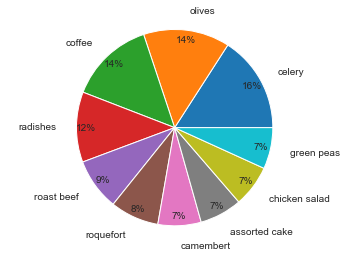

In [250]:
get_piechart(get_db_location_dish(input()))

#### New York

Всего заведений в данном месте: 3690


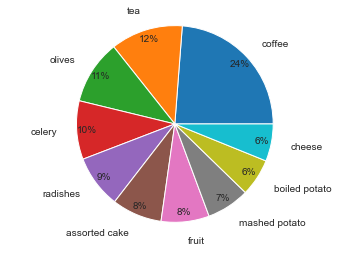

In [241]:
get_piechart(get_db_location_dish('new york'))

#### Los Angeles

Всего заведений в данном месте: 8


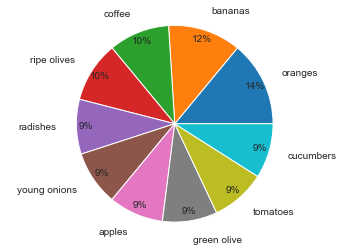

In [252]:
get_piechart(get_db_location_dish('los angeles'))

### 4. Самый редкие и дорогостоящие блюда

In [262]:
rare_and_pricy = FinalMenu[["name_lemm", "menus_appeared", "highest_price", 'date']]
rare_and_pricy = rare_and_pricy.loc[rare_and_pricy['menus_appeared'] == 1].dropna()
rare_and_pricy.sort_values('highest_price', ascending=False).head(10)

,name_lemm,menus_appeared,highest_price,date
914614,luso,1,1100.0,1987.0
901468,helados diversos,1,800.0,1958.0
1116853,dom perignon champagne,1,500.0,1971.0
1116850,charles heidsieck champagne,1,450.0,1971.0
1116848,ayala champagne,1,450.0,1971.0
1298192,special raised squab turkey,1,400.0,1912.0
1315454,g. h. mumm & co. extra dpy,1,400.0,1913.0
1116852,pomery champagne,1,400.0,1971.0
1298011,special raised squab turkey,1,400.0,1912.0
1116849,cordon rouge champagne,1,400.0,1971.0


### 5. Топ-10 часто встречающиеся позиции в меню

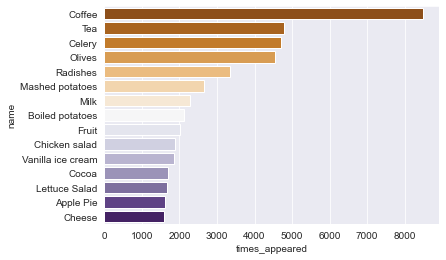

In [272]:
Dish = pd.read_csv("Dish.csv", sep=",")
Dish = Dish[["name", "times_appeared"]]
Dish = Dish.sort_values(by='times_appeared', ascending=False).head(15)
sns.set_style('darkgrid')
times = sns.barplot(x='times_appeared', y='name', data=Dish, palette='PuOr')
pic = times.get_figure()

### 6. Топ-10 самых дорогих позиций в меню

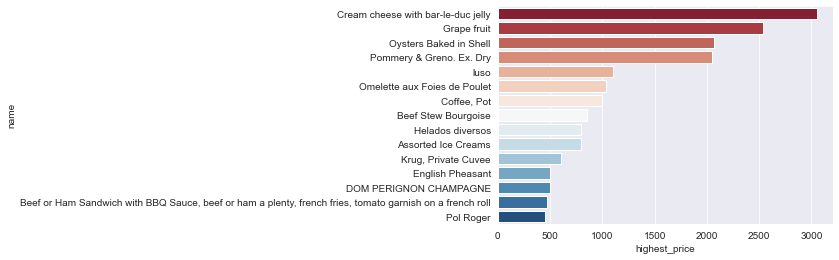

In [271]:
Price = pd.read_csv("Dish.csv", sep=",")
Price = Price[["name", "highest_price"]]
Price = Price.sort_values(by='highest_price', ascending=False).head(15)
sns.set_style('darkgrid')
p = sns.barplot(x = 'highest_price', y = 'name', data = Price, palette = 'RdBu')
pic1 = p.get_figure()